In [41]:
!pip install yahoofinancials
!pip install ta

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [42]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.plotting import scatter_matrix
import math
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from yahoofinancials import YahooFinancials

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR, SVC, LinearSVC, LinearSVR
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.gaussian_process import GaussianProcessRegressor
from keras import Sequential
from keras.layers import Dense, LSTM, Flatten
from pandas.tseries.offsets import BDay

from ta import *

%matplotlib inline

In [43]:
def getData(tickers,start,end):
    '''
    The function to download data from Yahoo Finance API. It takes a list of tickers, start date
    and end date, which is the last trading date. The return is a dataframe containing the
    tickers' adjusted close price and volume.

    Parameters:
        tickers: A list of tickers.
        start_date: The start date for fetching the data.
        end_date: The last date to fetch the data.
    Returns:
        df: Dataframe that contains the tickers' adjusted close price and volume.
    '''
    df = pd.DataFrame()
    if(len(tickers) > 0):
        for ticker in tickers:
            yahoo_financials = YahooFinancials(ticker)
            daily = yahoo_financials.get_historical_price_data(start, end, 'daily')

            daily = daily.get(ticker).get('prices') 
            df_temp = pd.DataFrame.from_records(daily)
            df_temp = df_temp.drop(['close','date','high','low','open'],axis=1)
            df_temp = df_temp.rename(columns={'formatted_date':'date','adjclose':ticker, 'volume':ticker +'_volume' })
            df_temp['date'] = pd.to_datetime(df_temp['date'])
            df_temp.set_index('date', inplace=True)
            df = pd.concat([df,df_temp],axis=1)
    
    return df

In [44]:
tickers = ['GOOG' , 'SPY']
ticker_of_interest = 'GOOG'
start_date = datetime.datetime(2011,1,1).date()
end_date = datetime.datetime(2018,12,31).date()
today = datetime.datetime.now().date()
number_of_days_to_predict = 5
df = getData(tickers, start_date.strftime("%Y-%m-%d"), today.strftime("%Y-%m-%d"))

In [45]:
df.tail(20)

,GOOG,GOOG_volume,SPY,SPY_volume
date,,,,
2019-06-14,1085.349976,1111500,287.859955,52324700
2019-06-17,1092.500000,941600,287.969391,39205700
2019-06-18,1103.599976,1386700,290.984741,85434800
2019-06-19,1102.329956,1338800,291.641541,78674400
2019-06-20,1111.420044,1262000,294.427979,116570000
2019-06-21,1121.880005,1947600,294.000000,83309500
2019-06-24,1115.520020,1395600,293.640015,47582700
2019-06-25,1086.349976,1546900,290.760010,82028700
2019-06-26,1079.800049,1810900,290.470001,51584900


In [46]:
df.describe()

,GOOG,GOOG_volume,SPY,SPY_volume
count,2145.000000,2.145000e+03,2145.000000,2.145000e+03
mean,654.857349,3.046547e+06,186.106369,1.206068e+08
std,295.323901,2.475931e+06,56.153005,6.782113e+07
min,236.553345,7.900000e+03,93.996262,2.785650e+07
25%,390.062958,1.411900e+06,133.613846,7.556370e+07
50%,578.362122,2.141400e+06,186.167648,1.038520e+08
75%,920.289978,4.098200e+06,230.488312,1.464367e+08
max,1287.579956,2.819250e+07,300.649994,7.178287e+08


In [47]:
df.isna().sum()

GOOG           0
GOOG_volume    0
SPY            0
SPY_volume     0
dtype: int64

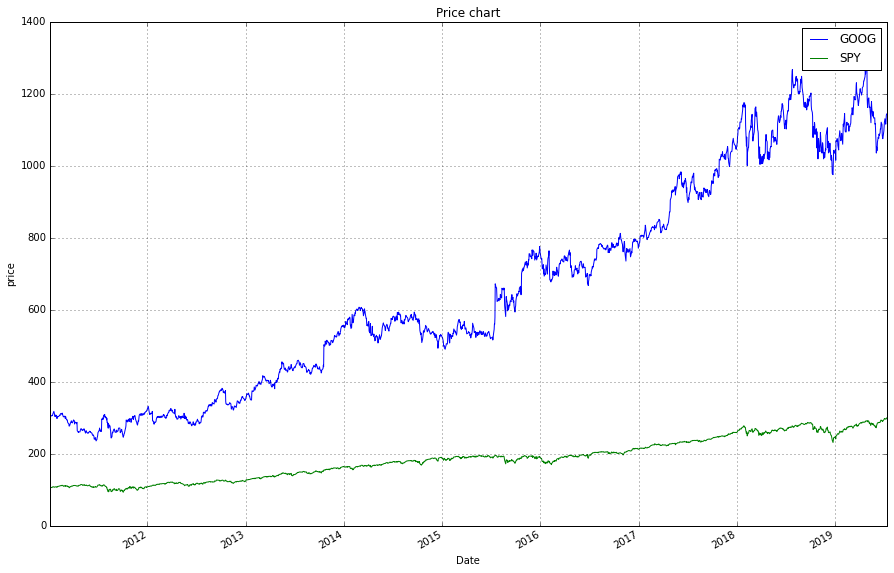

In [48]:
for ticker in tickers:
    ax = df[ticker].plot(title=ticker, figsize=(15,10), label=ticker)
    ax.legend()
    ax.grid()
    
plt.xlabel('Date')
plt.ylabel('price')
plt.title('Price chart')
plt.show()

In [49]:
def introduce_features(tickers, number_of_days_to_predict, df=df):
    '''
    The function to calculate different indecators and add it to the original
    dataframe. The indicatores are:
        * Daily percentage of change
        * Moving averages of different window sizes (10,100)
        * Bollinger Bands for each moving average
        * RSI
        * Force Index
        * On Balance Volume
        * EMA

    Parameters:
        df: Dataframe the contains the daily close price.
        ticker_of_interest: The ticker that will be predicted.
        tickers: A list of tickers.
        number_of_days_to_predict: number of days that wanted to be predicted
    Returns:
        df: Dataframe that contains the tickers' adjusted close price along
        with the calculated indecators and temporary future prices
    '''
    for ticker in tickers:
        print(ticker)
        #close_price = df[ticker] / df[ticker][0]
        close_price = df[ticker]
        df[ticker] = close_price
        daily_pct = close_price.pct_change(1)
        df[ticker + '_pct'] = daily_pct
        
        # Calculate the 5 days moving averages of the closing prices
        short_rolling = close_price.rolling(window=5).mean()
        df[ticker + '_short_rolling_5'] = short_rolling
        short_rolling_std = short_rolling.std()
        df[ticker + '_short_upper_band_5'] = df[ticker + '_short_rolling_5'] + (2 * short_rolling_std)
        df[ticker + '_short_lower_band_5'] = df[ticker + '_short_rolling_5'] - (2 * short_rolling_std)
        
        short_rolling = close_price.rolling(window=10).mean()
        df[ticker + '_short_rolling_10'] = short_rolling
        short_rolling_std = short_rolling.std()
        df[ticker + '_short_upper_band_10'] = df[ticker + '_short_rolling_10'] + (2 * short_rolling_std)
        df[ticker + '_short_lower_band_10'] = df[ticker + '_short_rolling_10'] - (2 * short_rolling_std)

        long_rolling = close_price.rolling(window=100).mean()
        df[ticker + '_long_rolling'] = long_rolling
        long_rolling_std = long_rolling.std()
        df[ticker + '_long_upper_band'] = df[ticker + '_long_rolling'] + (2 * long_rolling_std)
        df[ticker + '_long_lower_band'] = df[ticker + '_long_rolling'] - (2 * long_rolling_std)
        
        df[ticker + '_rsi_5'] = momentum.rsi(df[ticker], n=5, fillna=False)
        df[ticker + '_rsi_10'] = momentum.rsi(df[ticker], n=10, fillna=False)
        df[ticker + '_rsi_100'] = momentum.rsi(df[ticker], n=100, fillna=False)
        
        df[ticker + '_force_index_5'] = volume.force_index(df[ticker], df[ticker + '_volume'], n=5, fillna=False)
        df[ticker + '_force_index_10'] = volume.force_index(df[ticker], df[ticker + '_volume'], n=10, fillna=False)
        df[ticker + '_force_index_100'] = volume.force_index(df[ticker], df[ticker + '_volume'], n=100, fillna=False)
        
        df[ticker + '_obv'] = volume.on_balance_volume(df[ticker], df[ticker + '_volume'], fillna=False)
        
        df[ticker + '_ema_5'] = trend.ema_indicator(df[ticker], n=5, fillna=False)
        df[ticker + '_ema_10'] = trend.ema_indicator(df[ticker], n=10, fillna=False)
        df[ticker + '_ema_100'] = trend.ema_indicator(df[ticker], n=100, fillna=False)
        
        #df[ticker + '_trix_5'] = trend.trix(df[ticker], n=5, fillna=False)
        #df[ticker + '_trix_10'] = trend.trix(df[ticker], n=10, fillna=False)
        #df[ticker + '_trix_64'] = trend.trix(df[ticker], n=100, fillna=False)
        
        if(ticker != ticker_of_interest):
            pass
            
        else:
            df[ticker + '_future_price'] = np.concatenate((close_price[number_of_days_to_predict:].values, [np.nan]*number_of_days_to_predict))
            
    df = df.fillna(method='backfill')
    df = df.fillna(method='pad')
        
    return df

In [50]:
more_features = introduce_features(tickers, number_of_days_to_predict, df)
more_features

GOOG
SPY


,GOOG,GOOG_volume,SPY,SPY_volume,GOOG_pct,GOOG_short_rolling_5,GOOG_short_upper_band_5,GOOG_short_lower_band_5,GOOG_short_rolling_10,GOOG_short_upper_band_10,...,SPY_rsi_5,SPY_rsi_10,SPY_rsi_100,SPY_force_index_5,SPY_force_index_10,SPY_force_index_100,SPY_obv,SPY_ema_5,SPY_ema_10,SPY_ema_100
date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,301.046600,4748100,107.077354,138725200,-0.003690,303.410742,893.152466,-286.330981,305.526813,894.284126,...,30.217127,84.855684,52.160688,9.631802e+05,-5.063533e+07,1.437285e+08,-1.374097e+08,107.257938,107.926546,112.046371
2011-01-04,299.935760,3662600,107.018349,137409700,-0.003690,303.410742,893.152466,-286.330981,305.526813,894.284126,...,30.217127,84.855684,52.160688,9.631802e+05,-5.063533e+07,1.437285e+08,-1.374097e+08,107.257938,107.926546,112.046371
2011-01-05,303.397797,5083500,107.574608,133975300,0.011543,303.410742,893.152466,-286.330981,305.526813,894.284126,...,30.217127,84.855684,52.160688,9.631802e+05,-5.063533e+07,1.437285e+08,-3.434400e+06,107.257938,107.926546,112.046371
2011-01-06,305.604523,4131000,107.363914,122519000,0.007273,303.410742,893.152466,-286.330981,305.526813,894.284126,...,30.217127,84.855684,52.160688,9.631802e+05,-5.063533e+07,1.437285e+08,-1.259534e+08,107.257938,107.926546,112.046371
2011-01-07,307.069031,4218100,107.153206,156034600,0.004792,303.410742,893.152466,-286.330981,305.526813,894.284126,...,30.217127,84.855684,52.160688,9.631802e+05,-5.063533e+07,1.437285e+08,-2.819880e+08,107.257938,107.926546,112.046371
2011-01-10,305.958191,3170100,107.018349,122401700,-0.003618,304.393060,894.134784,-285.348663,305.526813,894.284126,...,30.217127,84.855684,52.160688,9.631802e+05,-5.063533e+07,1.437285e+08,-4.043897e+08,107.170389,107.926546,112.046371
2011-01-11,306.854828,2889300,107.397629,110287000,0.002931,305.776874,895.518597,-283.964850,305.526813,894.284126,...,65.843614,84.855684,52.160688,-1.028710e+07,-5.063533e+07,1.437285e+08,-2.941027e+08,107.250844,107.926546,112.046371
2011-01-12,307.283234,3277500,108.366859,107929200,0.001396,306.553961,896.295684,-283.187762,305.526813,894.284126,...,88.448827,84.855684,52.160688,-2.063506e+07,-5.063533e+07,1.437285e+08,-1.861735e+08,107.637954,107.926546,112.046371
2011-01-13,307.193573,2677900,108.189850,129048400,-0.000292,306.871771,896.613495,-282.869952,305.526813,894.284126,...,74.874150,84.855684,52.160688,5.392862e+06,-5.063533e+07,1.437285e+08,-3.152219e+08,107.826832,107.926546,112.046371


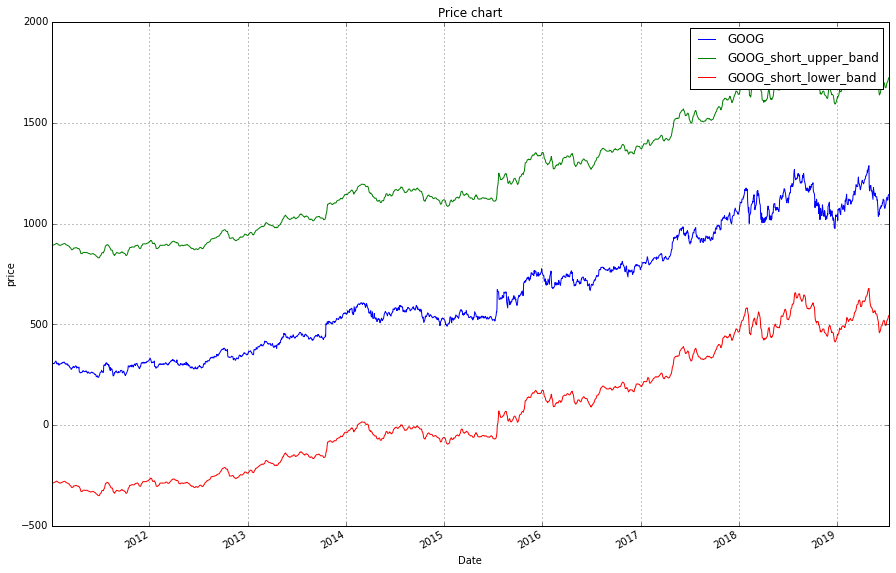

In [51]:
for ticker in tickers:
    if(ticker != ticker_of_interest):
        break
    else:
        ax = more_features[ticker].plot(title=ticker, label=ticker, figsize=(15,10))
        ax.legend()
        ax.grid()
        ax1 = more_features[ticker + '_short_upper_band_5'].plot(title=ticker+'_short_upper_band_5', label=ticker+'_short_upper_band', figsize=(15,10))
        ax1.legend()
        ax1.grid()
        ax2 = more_features[ticker + '_short_lower_band_5'].plot(title=ticker+'_short_lower_band_5', label=ticker+'_short_lower_band', figsize=(15,10))
        ax2.legend()
        ax2.grid()
    
plt.xlabel('Date')
plt.ylabel('price')
plt.title('Price chart')
plt.show()

In [52]:
all_features = more_features.drop([(ticker_of_interest + '_future_price')], axis=1)
all_mean = all_features.mean(axis = 0)
all_std = all_features.std(axis = 0)
all_features_normed = (all_features - all_mean) / all_std
all_target = more_features[ticker_of_interest + '_future_price']

n = all_features.shape[0]
small_features_size = int(n * 0.75)

training_features = all_features[:small_features_size]
training_mean = training_features.mean(axis = 0)
training_std = training_features.std(axis = 0)
training_features_normed = (training_features - training_mean) / training_std
training_target = all_target[:small_features_size]

n = training_features.shape[0]
small_features_size = int(n * 0.75)

small_features = all_features[:small_features_size]
small_mean = small_features.mean(axis = 0)
small_std = small_features.std(axis = 0)
small_features_normed = (small_features - small_mean) / small_std
small_target = all_features[:small_features_size]

features_validation = all_features[small_features_size:]
features_validation_normed = (features_validation - training_mean) / training_std
price_validation = more_features[ticker_of_interest][small_features_size:]
future_price_validation = more_features[ticker_of_interest + '_future_price'][small_features_size:]


In [53]:
def train_predict(models, X_train, y_train, X_test, y_test, price_validation):
    """
    The function loop through list of models and fit the training set
    then it prints the r2 score.
  
    Parameters: 
        models (list): The list of models.
        X_train: Features training set.
        y_train: Target training set.
        
        
    """
    for model in models:
        print("Train using: " , model.__class__.__name__)
        model.fit(X_train,y_train)
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)
        print("r2 score for train: ",r2_score(y_train,train_predict))
        
        print("r2 score for test: ",r2_score(y_test,test_predict))
        print(model)
        print()

In [54]:
models = []
models.append(LinearRegression())
models.append(DecisionTreeRegressor())
models.append(RandomForestRegressor())
models.append(SVR())
models.append(Lasso())
models.append(ElasticNet())
models.append(GradientBoostingRegressor())
models.append(AdaBoostRegressor())
models.append(KNeighborsRegressor())

train_predict(models, training_features_normed, training_target, features_validation_normed, future_price_validation, price_validation)


('Train using: ', 'LinearRegression')
('r2 score for train: ', 0.99196155273099862)
('r2 score for test: ', 0.96795811276985422)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
()
('Train using: ', 'DecisionTreeRegressor')
('r2 score for train: ', 1.0)
('r2 score for test: ', 0.5900093707227676)
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
()
('Train using: ', 'RandomForestRegressor')
('r2 score for train: ', 0.99941085634096949)
('r2 score for test: ', 0.58048074254199578)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_sa

In [55]:
def tune_parameters(model, parameters, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(model, parameters, scoring = 'r2', return_train_score=True, verbose=1)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

    train_predict = grid_search.predict(X_train)
    test_predict = grid_search.predict(X_test)

    print("r2 score for train: ",r2_score(y_train,train_predict))
    print("r2 score for test: ",r2_score(y_test,test_predict))
    
    return grid_search

In [56]:
lr_model = LinearRegression()
parameters = {'fit_intercept': [True,False],
                'normalize': [True,False],
             }

#parameters = {'max_depth': [None],
#              'min_samples_leaf':[2], 
#              'n_estimators' : [400]
#             }


lr_tuned = tune_parameters(lr_model, parameters, training_features_normed, training_target, features_validation_normed, future_price_validation)



Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'normalize': True, 'fit_intercept': False}
('r2 score for train: ', 0.99136225686036838)
('r2 score for test: ', 0.96589196314371362)


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished


In [57]:
lso_model = Lasso(random_state = 50)
#parameters = { 'alpha':[0.0001, 0.001, 0.02, 0.025, 0.03, 0.1, 0.4, 0.7, 0.9],
#                'fit_intercept': [True,False],
#                'normalize':[True,False], 
#                'max_iter' : [1,5,20,100,200],
#                'tol': [1,5,20,100,200],
#                'warm_start': [True,False],
#                'positive' :[True,False]
#             }

parameters = { 'alpha':[0],
                'fit_intercept': [True],
                'normalize':[True], 
                'max_iter' : [1],
                'tol': [1],
                'warm_start': [True],
                'positive' :[True]
             }

lso_tuned = tune_parameters(lso_model, parameters, training_features_normed, training_target, features_validation_normed, future_price_validation)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
{'normalize': True, 'warm_start': True, 'fit_intercept': True, 'positive': True, 'max_iter': 1, 'tol': 1, 'alpha': 0}
('r2 score for train: ', 0.9913721680167138)
('r2 score for test: ', 0.96769162181932211)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [58]:
en_model = ElasticNet(random_state = 50)
#parameters = { 'alpha':[0.00001, 0.0001, 0.001, 0.02, 0.025, 0.03, 0.1, 0.4, 0.7, 0.9],
#                'l1_ratio' : [0.00001, 0.0001, 0.001, 0.02, 0.025, 0.03, 0.1, 0.4, 0.7, 0.9],
#                'fit_intercept': [True,False],
#                'normalize':[True,False], 
#                'max_iter' : [1,5,20,100,200],
#                'tol': [1,5,20,100,200],
#                'warm_start': [True,False],
#                'positive' :[True,False]
#             }

parameters = { 'alpha':[0.0001],
                'l1_ratio' : [0.4],
                'fit_intercept': [True],
                'normalize':[True], 
                'max_iter' : [1],
                'tol': [1],
                'warm_start': [True],
                'positive' :[True]
             }

en_tuned = tune_parameters(en_model, parameters, training_features_normed, training_target, features_validation_normed, future_price_validation)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
{'normalize': True, 'warm_start': True, 'fit_intercept': True, 'l1_ratio': 0.4, 'max_iter': 1, 'tol': 1, 'positive': True, 'alpha': 0.0001}
('r2 score for train: ', 0.99120017062620891)
('r2 score for test: ', 0.9689240049498935)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [59]:
model = en_tuned.fit(all_features_normed,all_target)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [60]:
predictions = pd.DataFrame(columns=['Date', 'Predicted Price'])
current_date = datetime.datetime(2019,1,2)
next_day = current_date
for i in range(number_of_days_to_predict):
    print(i)
    print(next_day)
    try:
        value_to_predict = all_features_normed.loc[next_day].values
        value_to_predict = value_to_predict.reshape(1, -1)
        predict_current = model.predict(value_to_predict)
        future_date = next_day + BDay(number_of_days_to_predict)
        print(future_date)
        predictions.loc[i] = [future_date] + [predict_current[0]]
        next_day = next_day + BDay()
    except:
        print (sys.exc_info()[0])

0
2019-01-02 00:00:00
2019-01-09 00:00:00
1
2019-01-03 00:00:00
2019-01-10 00:00:00
2
2019-01-04 00:00:00
2019-01-11 00:00:00
3
2019-01-07 00:00:00
2019-01-14 00:00:00
4
2019-01-08 00:00:00
2019-01-15 00:00:00


In [61]:
predictions

,Date,Predicted Price
0,2019-01-09,1041.231363
1,2019-01-10,1011.562120
2,2019-01-11,1064.469981
3,2019-01-14,1063.638122
4,2019-01-15,1071.952805


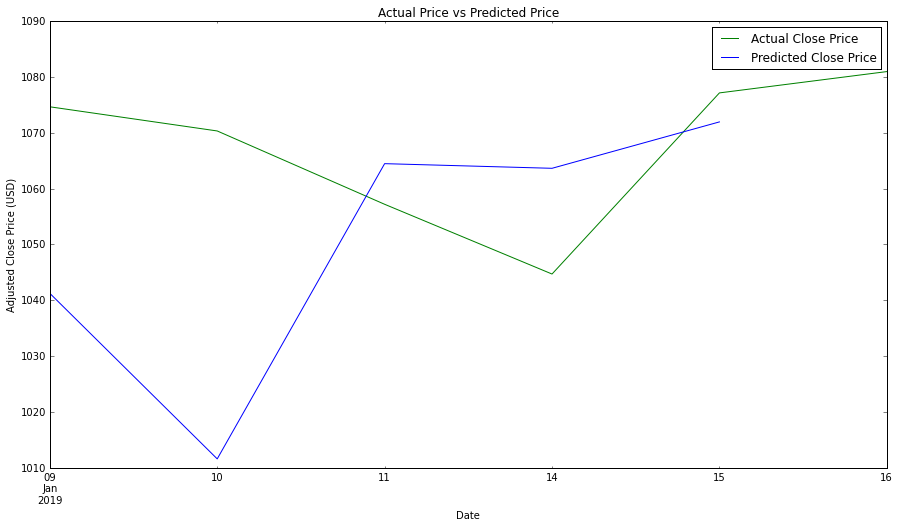

In [62]:
actual_price = all_features.loc[(current_date + BDay(number_of_days_to_predict)):(current_date + (2*BDay(number_of_days_to_predict)))][ticker_of_interest]
predict_price = predictions['Predicted Price']


predict_price.index = predictions['Date']
fig, ax = plt.subplots( nrows=1, ncols=1 )
fig.set_size_inches(15, 8)
actual_price.plot(ax = ax, title = "Actual Price vs Predicted Price", label="Actual Price", color="green")
predict_price.plot(ax = ax, label="Predicted Price", color="blue")

plt.gca().legend(('Actual Close Price','Predicted Close Price'))

ax.set_xlabel("Date")
ax.set_ylabel("Adjusted Close Price (USD)")

In [63]:
future_date = current_date + BDay(number_of_days_to_predict)
pct = []
for i in range(number_of_days_to_predict):
    actual_price = more_features.loc[future_date][ticker_of_interest]
    print(future_date)
    print('actual price' , actual_price)
    predict_price = predictions.loc[i]['Predicted Price']
    print('pred price' , predict_price)
    pct.append(((float(predict_price)-actual_price)/actual_price)*100)
    print(pct[i])
    future_date = future_date + BDay()
pct

2019-01-09 00:00:00
('actual price', 1074.6600341796875)
('pred price', 1041.2313631695461)
-3.11062754238
2019-01-10 00:00:00
('actual price', 1070.3299560546875)
('pred price', 1011.5621198570411)
-5.49062799422
2019-01-11 00:00:00
('actual price', 1057.18994140625)
('pred price', 1064.4699808619393)
0.688621710305
2019-01-14 00:00:00
('actual price', 1044.68994140625)
('pred price', 1063.6381218675203)
1.8137611659
2019-01-15 00:00:00
('actual price', 1077.1500244140625)
('pred price', 1071.9528051200136)
-0.482497254445


[-3.1106275423797918,
 -5.490627994218606,
 0.68862171030549202,
 1.8137611658981156,
 -0.48249725444475544]

In [64]:
first_date = current_date + BDay(number_of_days_to_predict)
last_date = first_date + BDay(number_of_days_to_predict) - BDay(1)
actual_pct = (more_features.loc[last_date][ticker] - more_features.loc[first_date][ticker] ) / more_features.loc[first_date][ticker]
predict_pct = (predictions.iloc[-1]['Predicted Price'] - predictions.loc[0]['Predicted Price'] ) / predictions.loc[0]['Predicted Price']
print(actual_pct*100)
print(predict_pct*100)
print((actual_pct - predict_pct)*100)

0.922587758967
2.95049141211
-2.02790365314
